In [3]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Arc
from matplotlib.pyplot import figure

In [26]:
data = np.load("circles.npy")

In [27]:
data.min(axis=0), data.max(axis=0)

(array([3.16073590e-05, 1.27236613e-03]), array([0.99507221, 0.99983261]))

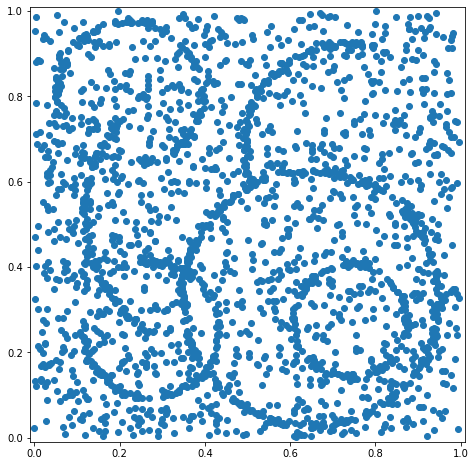

In [28]:
fig, ax = plt.subplots(figsize=(8,8))

plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
plt.gca().set_aspect('equal', adjustable='box')
ax.scatter(*data.T)

plt.show()

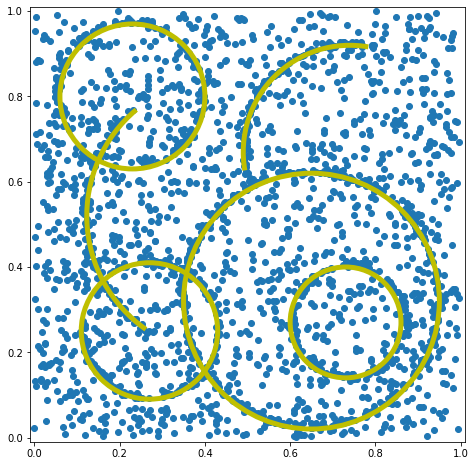

In [293]:
fig, ax = plt.subplots(figsize=(8,8))

plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
plt.gca().set_aspect('equal', adjustable='box')
ax.scatter(*data.T)

color = "y"
linewidth = 5

ax.add_patch(Arc((.448, .52), .65, .65, theta1=130, theta2=235, color=color, linewidth=linewidth))
ax.add_patch(Arc((.74, .67), .5, .5, theta1=80, theta2=190, color=color, linewidth=linewidth))
ax.add_patch(plt.Circle((.23, .8), .17, fill=False, color=color, linewidth=linewidth))
ax.add_patch(plt.Circle((.27, .25), .16, fill=False, color=color, linewidth=linewidth))
ax.add_patch(plt.Circle((.65, .32), .3, fill=False, color=color, linewidth=linewidth))
ax.add_patch(plt.Circle((.73, .27), .13, fill=False, color=color, linewidth=linewidth))

plt.show()

In [416]:
def circle_touching_three_points_vec(points):
    """This adapts the formular outlined here: https://en.wikipedia.org/wiki/Circumscribed_circle#Cartesian_coordinates
    It expects three points in R2, so dim(points) = 3x2
    """
    xs = points[:, :,0]
    ys = points[:, :,1]
    ones = np.ones(list(points.shape)[:2])
    len_squared = np.linalg.norm(points, axis=2) ** 2

    def stack(a, b, c):
        return np.hstack([a, b, c]).reshape((points.shape[0], 3, 3))
    
    
    S_x = .5 * np.linalg.det(stack(len_squared, ys, ones))
    S_y = .5 * np.linalg.det(stack(xs, len_squared, ones))
    a = np.linalg.det(stack(xs, ys, ones))
    b = np.linalg.det(stack(xs, ys, len_squared))
    
    S = np.array([S_x, S_y]).T
    center = S/a[:, None]
    radius = np.sqrt((b / a ) + (np.linalg.norm(S, axis=1) ** 2 / a ** 2))

    return np.vstack([center.T, radius]).T

In [379]:
def ransac(data, number_of_circles, N, epsilon):
    """
        number_of_circles: number of circles to find
        N: iterations per circle
    """
    best_circles = []
    filtered_out_points = None
    
    for _ in range(number_of_circles):
        R = np.zeros((N, 3, 2))
        M = data.shape[0]
        for i in range(N):
            random_index = np.random.choice(np.arange(M), size=3, replace=True)
            R[i] = data[random_index] 
        C = circle_touching_three_points_vec(R)
        centers = C[:, :2]
        radius = C[:, 2]

        distances_to_centers = np.linalg.norm(data - centers[:, None, :], axis=2)
        distance_to_circle = np.abs(distances_to_centers - radius[:, None])
        close_to_circle = distance_to_circle < epsilon
        inliers = close_to_circle.sum(axis=1)

        best_circle_idx = inliers.argmax()
        best_circle = C[best_circle_idx]
    
        best_circles.append(best_circle)
    
        # filter out all points used to construct the current best circle
        data = data[~close_to_circle[best_circle_idx]]
          
    return best_circles, data

a is zero!!!


<ipython-input-364-a284b55eb37e>:24: RuntimeWarning: divide by zero encountered in true_divide
  center = S/a[:, None]
<ipython-input-364-a284b55eb37e>:24: RuntimeWarning: invalid value encountered in true_divide
  center = S/a[:, None]
<ipython-input-364-a284b55eb37e>:25: RuntimeWarning: divide by zero encountered in true_divide
  radius = np.sqrt((b / a ) + (np.linalg.norm(S, axis=1) ** 2 / a ** 2))
<ipython-input-364-a284b55eb37e>:25: RuntimeWarning: invalid value encountered in true_divide
  radius = np.sqrt((b / a ) + (np.linalg.norm(S, axis=1) ** 2 / a ** 2))
<ipython-input-364-a284b55eb37e>:25: RuntimeWarning: invalid value encountered in add
  radius = np.sqrt((b / a ) + (np.linalg.norm(S, axis=1) ** 2 / a ** 2))
<ipython-input-379-57c510377524>:20: RuntimeWarning: invalid value encountered in subtract
  distance_to_circle = np.abs(distances_to_centers - radius[:, None])


a is zero!!!
a is zero!!!
a is zero!!!


<ipython-input-364-a284b55eb37e>:25: RuntimeWarning: invalid value encountered in sqrt
  radius = np.sqrt((b / a ) + (np.linalg.norm(S, axis=1) ** 2 / a ** 2))


a is zero!!!
a is zero!!!


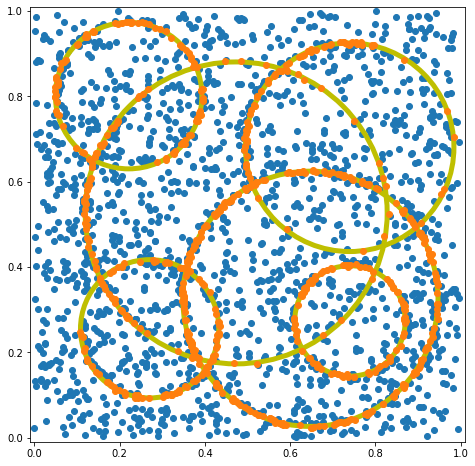

In [415]:
circles, data_filter = ransac(data, number_of_circles=6, N=10_000, epsilon=0.004)

fig, ax = plt.subplots(figsize=(8,8))

plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
plt.gca().set_aspect('equal', adjustable='box')
ax.scatter(*data_filter.T)

color = "y"
linewidth = 5

for circle in circles:
    center, radius = unpack_center_radius(circle)
    ax.add_patch(plt.Circle(center, radius, fill=False, color=color, linewidth=linewidth))

# plot the points that were used to create the circles
ax.scatter(*data[~(np.isin(data, data_filter))[:, 0]].T)

plt.show()

The result is sensitive to epsilon. When epsilon is too low, not enough points are removed once a circle is found as best circle for one iteration. When epsilon is too high the algorithm just selects large circles that cover a big distances and therefor come near a lot of points. 

In [ ]:
! git add fitting_c